In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


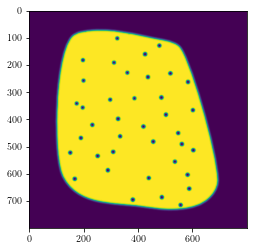

In [9]:
mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 2


#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
        
plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')


In [10]:
fsky = np.sum(apodized_mask) / np.sum(np.ones_like(apodized_mask))

In [11]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key != 'kCmbF_1'):
            continue
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]

kCmbF_1 (500, 800, 401)


In [12]:
pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [13]:
data = {}
# pbar = trange(len(pairs))
for file_idx in trange(1,51):
    for pair_idx in range(len(pairs)):
        pair = pairs[pair_idx]
        
        f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_FILE%d_pair_%d_%d_MASKED.pkl'%(file_idx, pair[0], pair[1]), 'rb')  
        c_data = pickle.load(f)
        f.close()        
        for key in c_data:
            if(key not in data.keys()):
                data[key] = np.array(c_data[key])
            else:
                data[key] = np.vstack((data[key], np.array(c_data[key])))  
#             print(np.shape(data[key]))

100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


In [14]:
for key in data:
    print(key, np.shape(data[key]))

-1-1_m (500, 800, 401)
-1-1_m_sqrtN (500, 800, 401)
-2-2_m (500, 800, 401)
-2-2_m_sqrtN (500, 800, 401)


In [16]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [16]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/mean_field_800x800_20x20.pkl', 'rb') 
mean_field = pickle.load(f)
f.close()

In [17]:
nBins=51

ps_data = {}

# #estimate RDN0
# ck = 'RDN(0)'

# def tmp_combine_Cl(Cls_tot):
#     n_runs = np.shape(Cls_tot)[0]
#     lCen = Cls_tot[0][0]
#     Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
# #     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
#     return lCen, Cls, sCls


# for d_idx in trange(len(in_data['totalF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d.pkl'%(d_idx)
#     c_ps_data = None
#     try:
#         with open(RDN0_fname,"rb") as f:
#             c_ps_data = pickle.load(f)
#     except IOError:
#         continue
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array(c_ps_data[ck])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array(c_ps_data[ck])))  
# print(ps_data[ck].shape)

# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  



# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1_m'])):
    QE = data['-1-1_m'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field, nBins=nBins)
    c_ps_data[ck][1] /= fsky
    c_ps_data[ck][2] /= fsky

    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_m_sqrtN'])):
    sqrtNhat = data['-1-1_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    c_ps_data[ck][1] /= fsky**2
    c_ps_data[ck][2] /= fsky**2
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_m_sqrtN'])):
    sqrtNhat = data['-2-2_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  





ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])



import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 500

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

100%|██████████| 500/500 [00:08<00:00, 59.97it/s]


500 (500, 3, 50)


100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


500 (500, 3, 50)


In [19]:
labels={
    'N0':r'$N^{(0)}$',
    'GRF':r'$\hat N$ on GRF',
    'kT': r'$\left<\kappa\kappa\right>$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'RDN(0)':r'${\rm RDN}^{(0)}$',
    'RDN(0)o2':r'${\rm RDN}^{(0)}$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'QEQE-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
    'QEQE-2Nhat+Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-2\hat N+N_{\rm theory}$',
    'QEQE-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$',
    'QEQE-Ntheory-N1':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}-N^{(1)}$',
    'QEQE-N0':r'$\left<\hat\kappa\hat\kappa\right>- N^{(0)}$',
    'QEQE-kTkT-Nhat': r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-\hat N$',
    'QEQE-kTkT-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-N_{\rm theory}$',
    'QEQE-kTkT-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-{\rm RDN}^{(0)}$',

}

def graph_from_keys(c_keys, offset=0.03, factor=lambda x:1, pN1 = False):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'green', 'blue']))
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20

    ell = baseMap.l.flatten()
    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)

    if(pN1):
        n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
        indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
        bins = n1[0]
        n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
        for i in range(len(indices)):
            if(indices[i] != 'TT'):
                continue        
            n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
            KK = p2d_cmblens.fPinterp(bins)

            phiphi =  -2. * KK / bins**2
            phiphi *=  -2./ bins**2
            phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

            pp_n1 = phiphi+n1_pp

            KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
            KK_n1 *= - bins**2 / 2
            KK_n1 *= - bins**2 / 2
            plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')
        
        
    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])
    ax.set_title('Masked, Point Sources')

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

In [19]:
Ntheory_evaled.shape

(500, 3, 50)

In [20]:
# ps_data['QEQE-N0'] = combine_sketchy(ps_data['QEQE'], [ -ps_data['N0']])
# ps_data['QEQE-2Nhat+Ntheory'] = combine_sketchy(ps_data['QEQE'], [-2*ps_data['Nhat'],Ntheory_evaled])

In [21]:
# ps_data['RDN(0)o2'] = np.copy(ps_data['RDN(0)'])
# print(np.shape(ps_data['RDN(0)o2']))
# ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[1,2,0])

# ps_data['RDN(0)o2'][1] = ps_data['RDN(0)o2'][1]/2
# ps_data['RDN(0)o2'][2] = ps_data['RDN(0)o2'][2]/2

# ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[2,0,1])

# print(np.shape(ps_data['RDN(0)o2']))


In [26]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked.pkl', 'wb') 
pickle.dump(ps_data, f)
f.close()


In [13]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked.pkl', 'rb') 
ps_data = pickle.load(f)
f.close()


In [14]:

# graph_from_keys([  
#     'RDN(0)o2',
#     'Nhat',
# ], offset=0.00)
# plt.savefig('figures/RDN0.pdf', bbox_inches='tight')



500 (500, 3, 50)
500 (500, 3, 50)
500 (500, 3, 50)


(<Figure size 720x576 with 1 Axes>,
 <Axes: title={'center': 'Masked, Point Sources'}, xlabel='$\\ell$'>)

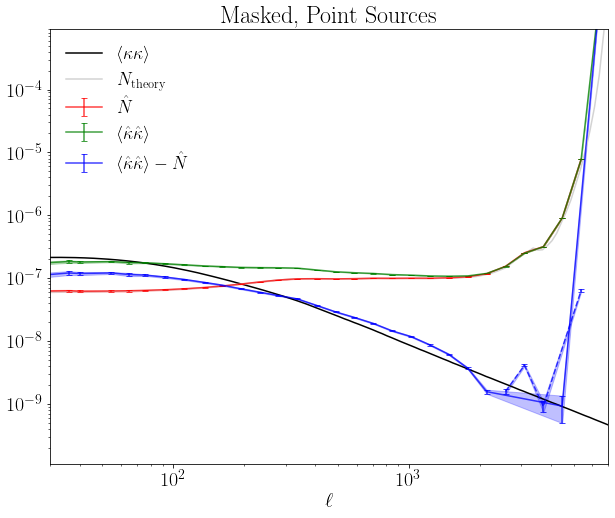

In [20]:
graph_from_keys([
#     'QEQE-N0',
    'Nhat',
    'QEQE',
    'QEQE-Nhat',
#     'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.00)


500 (500, 3, 50)
500 (500, 3, 50)


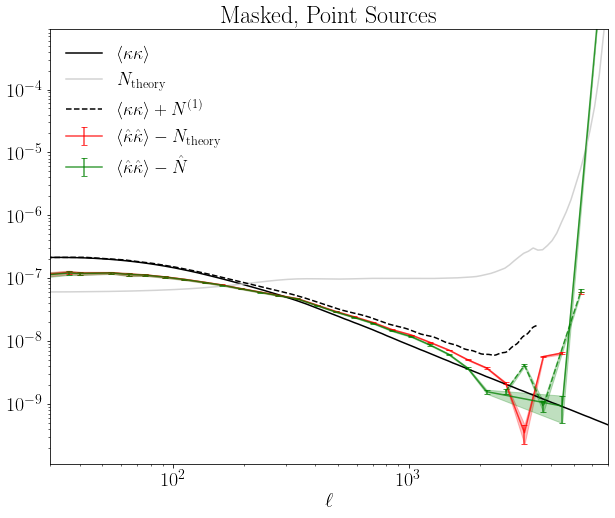

In [21]:
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Ntheory',
    'QEQE-Nhat',
#     'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.00, pN1=True)
plt.savefig('figures/mNhat_vs_mNtheory_masked.pdf', bbox_inches='tight')

In [25]:
# ps_data['QEQE-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0)o2']])
# graph_from_keys([
# #     'QEQE-N0',
#     'QEQE-Ntheory',
#     'QEQE-Nhat',
#     'QEQE-RDN(0)',
# #     'RDN(0)o2'
# #     'QEQE-2Nhat+Ntheory',
# ], offset=0.00)
# plt.savefig('figures/mNhat_vs_mNtheory_vs_RDN0.pdf', bbox_inches='tight')

In [27]:
nBins=15

ps_data = {}

# #estimate RDN0
# ck = 'RDN(0)'

# def tmp_combine_Cl(Cls_tot):
#     n_runs = np.shape(Cls_tot)[0]
#     lCen = Cls_tot[0][0]
#     Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
# #     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
#     return lCen, Cls, sCls


# for d_idx in trange(len(in_data['totalF_1'])):
#     RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d.pkl'%(d_idx)
#     c_ps_data = None
#     try:
#         with open(RDN0_fname,"rb") as f:
#             c_ps_data = pickle.load(f)
#     except IOError:
#         continue
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array(c_ps_data[ck])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array(c_ps_data[ck])))  
# print(ps_data[ck].shape)

# #estimate N0
# ck = 'N0'

# for data_idx in range(len(data['00'])):
#     q00 = data['00'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00, nBins=nBins)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  



# #estimate kk
# ck = 'kk'


# for data_idx in range(min(len(data['01']), len(data['10']))):
#     q01 = data['01'][data_idx]
#     q10 = data['10'][data_idx]
#     kCmbFourier = in_data['kCmbF_1'][data_idx]
#     c_ps_data = {}
#     c_ps_data[ck] = [0,0,0]
#     c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier, nBins=15)
#     if(ck not in ps_data.keys()):
#         ps_data[ck] = np.array([c_ps_data[ck]])
#     else:
#         ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <QE QE>
ck = 'QEQE'
for data_idx in trange(len(data['-1-1_m'])):
    QE = data['-1-1_m'][data_idx]

    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field, nBins=nBins)
    c_ps_data[ck][1] /= fsky
    c_ps_data[ck][2] /= fsky

    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate Nhat
ck = 'Nhat'
for data_idx in trange(len(data['-1-1_m_sqrtN'])):
    sqrtNhat = data['-1-1_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    c_ps_data[ck][1] /= fsky**2
    c_ps_data[ck][2] /= fsky**2
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(len(data['-2-2_m_sqrtN'])):
    sqrtNhat = data['-2-2_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

#estimate <kT kT>
ck = 'kT'

for data_idx in trange(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  





ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])



import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=nBins)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 500

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

100%|██████████| 500/500 [00:08<00:00, 60.55it/s]

500 (500, 3, 14)



100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


500 (500, 3, 14)


In [32]:
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/ps_data_masked_fewer_bins.pkl', 'wb') 
pickle.dump(ps_data, f)
f.close()


In [37]:
#bandaid
ll = ['%d'%l for l in ps_data['QEQE'][0][0]]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$\rho$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2))
    plt.xlim(4, len(ll)-1)
    plt.ylim(4, len(ll)-1)

    plt.savefig('figures/corr_%s_masked.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

In [38]:
# corr_gen(['QEQE', 'N0'], 'QEQEvsN0')

In [39]:
ps_data['QEQE-kTkT-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['Nhat']])
ps_data['QEQE-kTkT-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-Ntheory_evaled])
# ps_data['QEQE-kTkT-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['RDN(0)o2']])

500 (500, 3, 14)
500 (500, 3, 14)


(500, 3, 14)
(500, 3, 14)
(14, 14)
(14, 14)


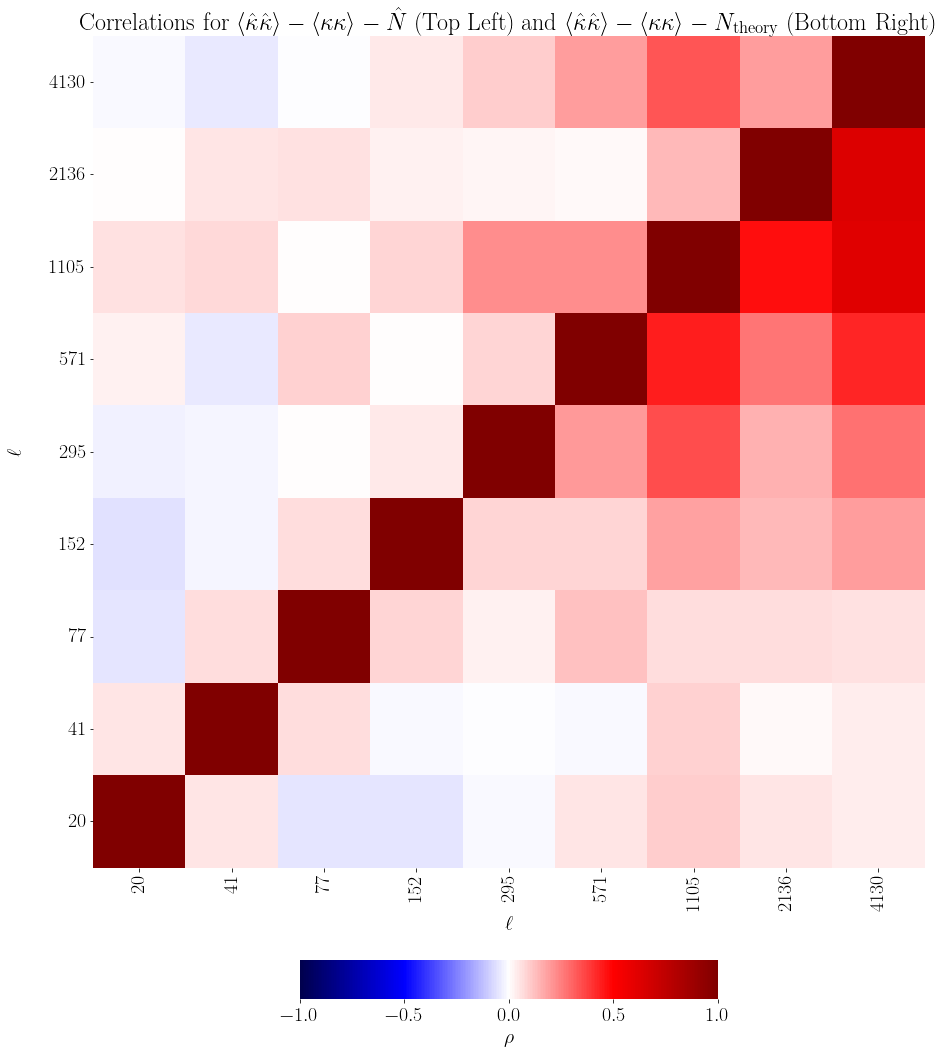

In [40]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-Ntheory'], 'mNhat_v_mNtheory')

In [ ]:
# corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-RDN(0)'], 'mNhat_v_mRDN0')